### Image Stitching

In this notebook we are going to demonstrate how feature detection and feature descriptors can help us to perform image stitching (in this case, to compose a panoramic view from 2 images). Let's start with the usual imports.

In [36]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

We will be working with 2 images that capture the same scene but with **different camera position and different time**. The objective is to transfrom the source image to align with the target image. In other words, we want to find the homography that thrasnforms the source view into the target view and use this homography to stitch the two images together.

(<Axes: title={'center': 'Target'}>,
 Text(0.5, 1.0, 'Target'))

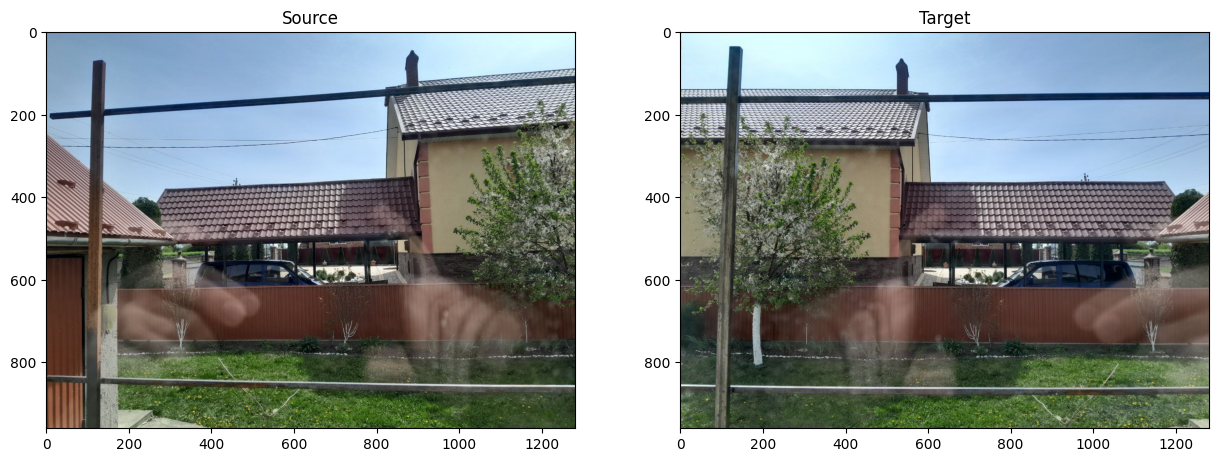

In [37]:
# Load source view
img_src = cv2.imread('data/shift2.jpg')
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)

# Load target view
img_dst = cv2.imread('data/shift1.jpg')
img_dst = cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB)

plt.subplot(121), plt.imshow(img_src), plt.title('Source')
plt.subplot(122), plt.imshow(img_dst), plt.title('Target')

### Feature Detection

In order to find the abovementioned homography, we need to find the pixel correspondences. To do so, we will be using the well-known SIFT features (you can use any detector + descriptor you want).

(<Axes: title={'center': 'Target'}>,
 Text(0.5, 1.0, 'Target'))

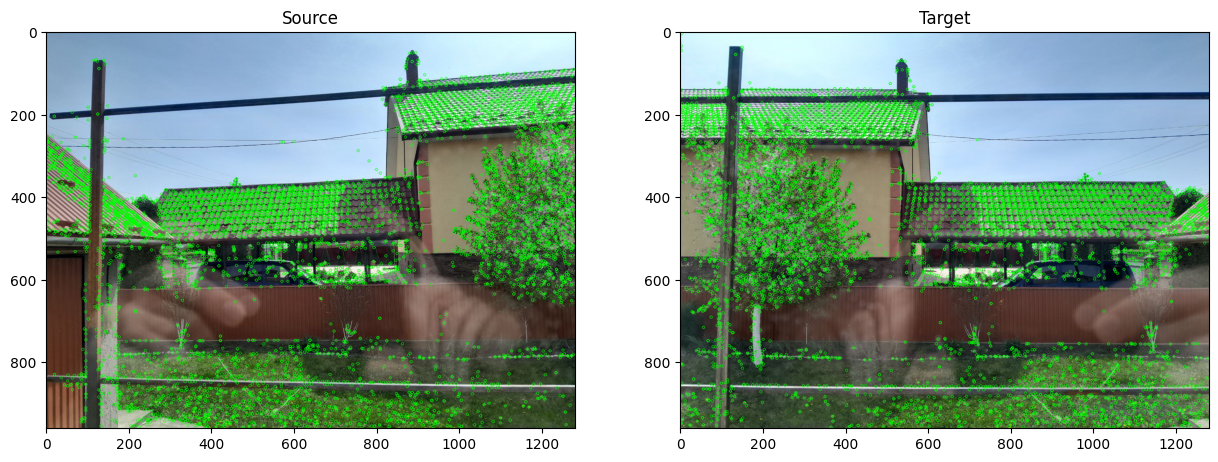

In [38]:
# Let's create the SIFT detector
descriptor = cv2.SIFT_create()

# We don't want to use any pixel mask, so we set it to None
(kps_src, features_src) = descriptor.detectAndCompute(img_src, None)
(kps_dst, features_dst) = descriptor.detectAndCompute(img_dst, None)

# Let's draw the detected features
feats_img_src = cv2.drawKeypoints(img_src, kps_src, None, color=(0,255,0))
feats_img_dst = cv2.drawKeypoints(img_dst, kps_dst, None, color=(0,255,0))

plt.subplot(121), plt.imshow(feats_img_src), plt.title('Source')
plt.subplot(122), plt.imshow(feats_img_dst), plt.title('Target')

We see there is **a lot** of detected features and many of them are not relevant to our task (e.g. the waves on the river surface).

### Feature Matching

Given the two sets of source and target features, we need to find the correspondences, i.e., for each feature on the source image we need to find the best matching feature on the target image. In this notebook, we will be using the **brute-force matcher with cross-check**.

In [39]:
# Brute-force matcher with cross-check
# Note: Euclidean norm, as the distance metric for feature descriptors, is suitable for SIFT,
# but not necessarilly for other decriptors.
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(features_src, features_dst)
    
# Sort the features in order of distance (merely for plotting purposes)
matches = sorted(matches, key = lambda x:x.distance)

# Show how many features we had originally and how many matches we found
print("Num features:", len(features_src), len(features_dst))
print("Num matches :", len(matches))

Num features: 7768 7999
Num matches : 1643


As you can see, the cross-check already took care and eliminated many of the irrelevant features (both on source and target side).

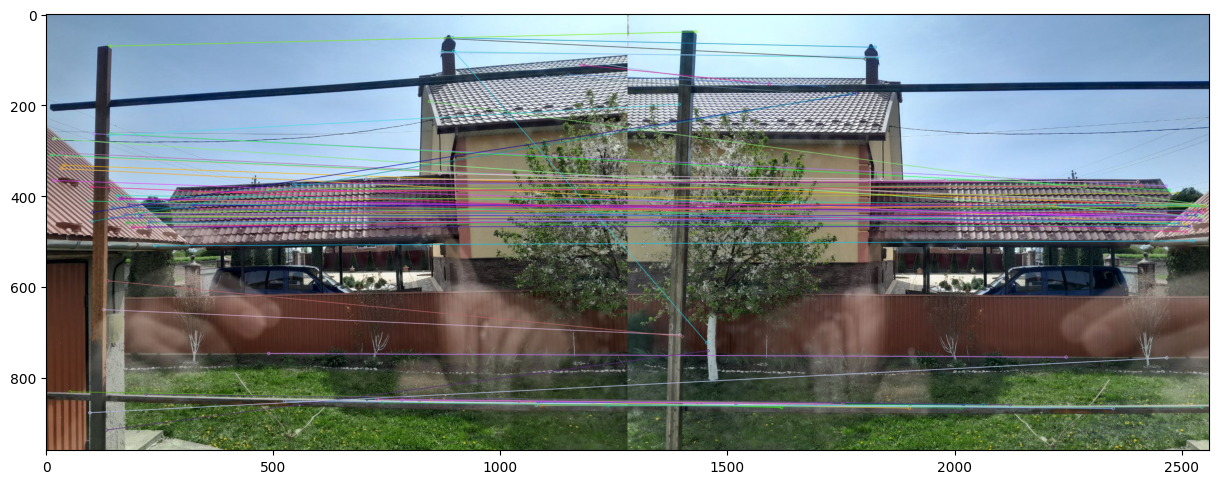

In [40]:
# Let's now draw the found matches (correspondences)
result = cv2.drawMatches(img_src, kps_src, img_dst, kps_dst, matches[:100],
                         None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(result)

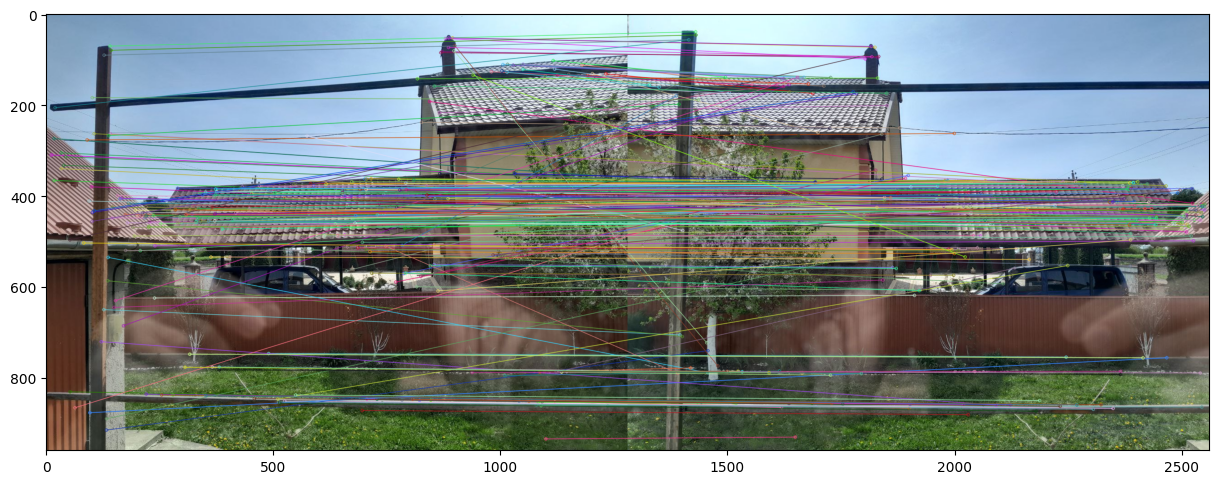

In [41]:
# Let's now draw the best fitting matches (correspondences)
result = cv2.drawMatches(img_src, kps_src, img_dst, kps_dst, matches[:300],
                         None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(result)

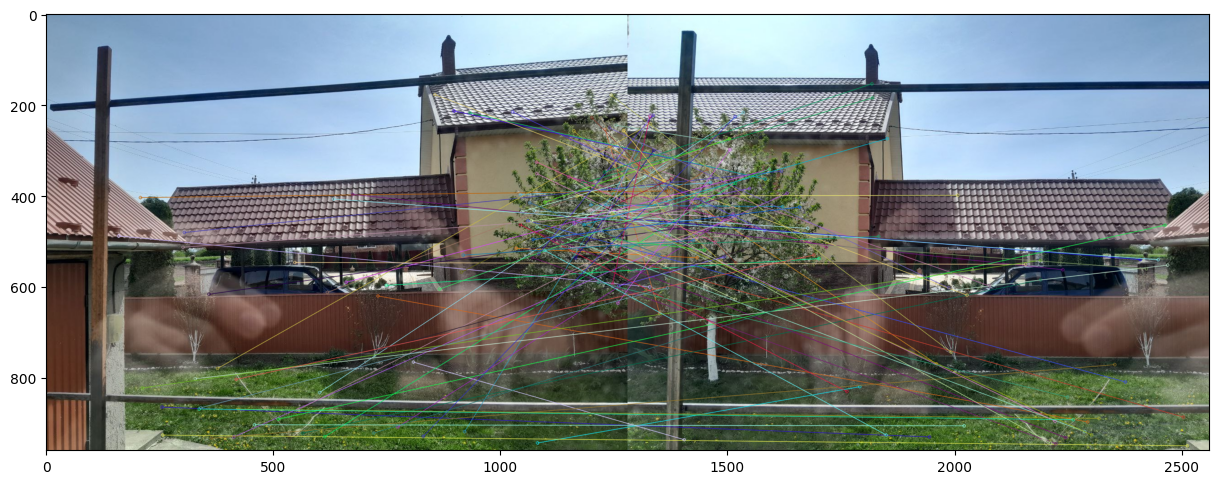

In [42]:
# Let's now draw the least fitting matches (correspondences)
result = cv2.drawMatches(img_src, kps_src, img_dst, kps_dst, matches[-100:],
                         None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(result)

Given the correspondeces (i.e. the set of source points and the set of target points) we are going to find the best fitting homography transform. We will also switch the RANSAC on since this is a **powerful tool** to eliminate outliers.

In [43]:
# Convert keypoints to numpy arrays
kps_src = np.float32([kp.pt for kp in kps_src])
kps_dst = np.float32([kp.pt for kp in kps_dst])

# Construct the two sets of points (source and target)
pts_src = np.float32([kps_src[m.queryIdx] for m in matches])
pts_dst = np.float32([kps_dst[m.trainIdx] for m in matches])

# Estimate homography between source and target (try to see what happens if we switch RANSAC off)
(H, status) = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 4)

print('Homography matrix:')
print(H)

Homography matrix:
[[-9.49936031e-01  3.32428880e-02  1.36383249e+03]
 [-1.73267265e-02  9.25222002e-01  4.58099448e+01]
 [-5.00130071e-05  2.02080012e-05  1.00000000e+00]]


### Image Stitching

Using the estimated homography, we are going to transform the source image to the target viewport and we will stitch the two images together.

(<matplotlib.image.AxesImage at 0x20b0f2bdb10>, (-0.5, 2559.5, 1919.5, -0.5))

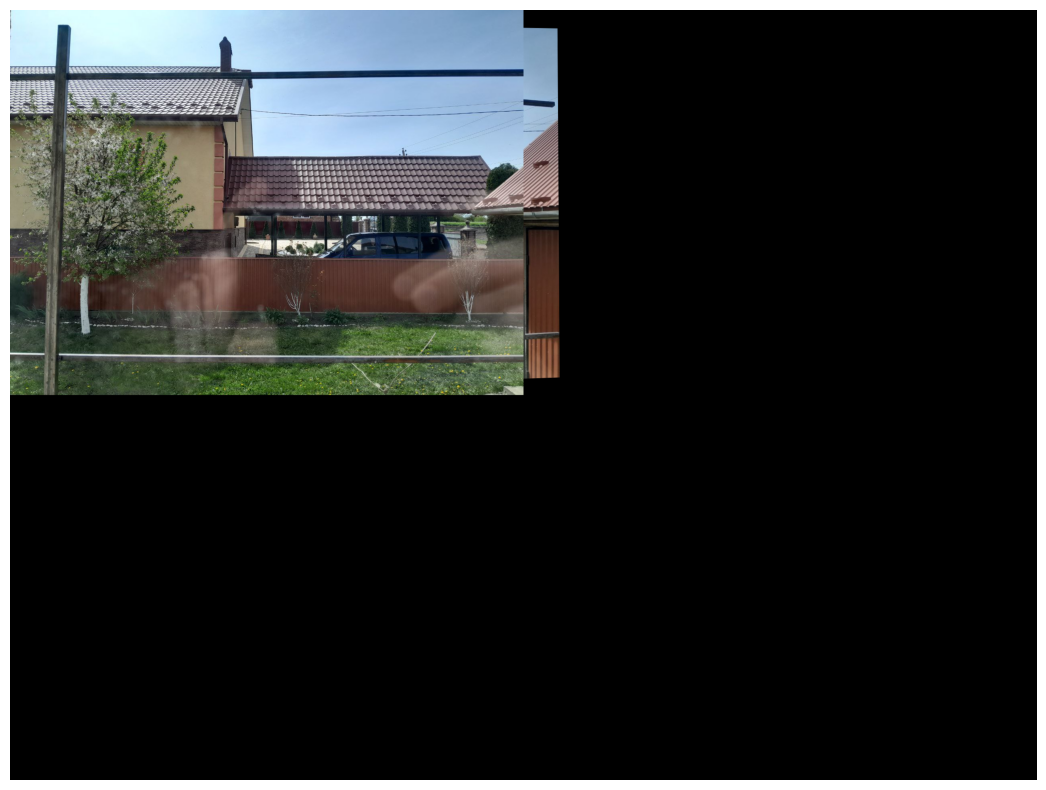

In [44]:
# Prepare canvas
width = img_src.shape[1] + img_src.shape[1]
height = img_src.shape[0] + img_src.shape[0]

# Generate the stitched image
result = cv2.warpPerspective(img_src, H, (width, height))
result[0:img_dst.shape[0], 0:img_dst.shape[1]] = img_dst

plt.imshow(result), plt.axis('off')

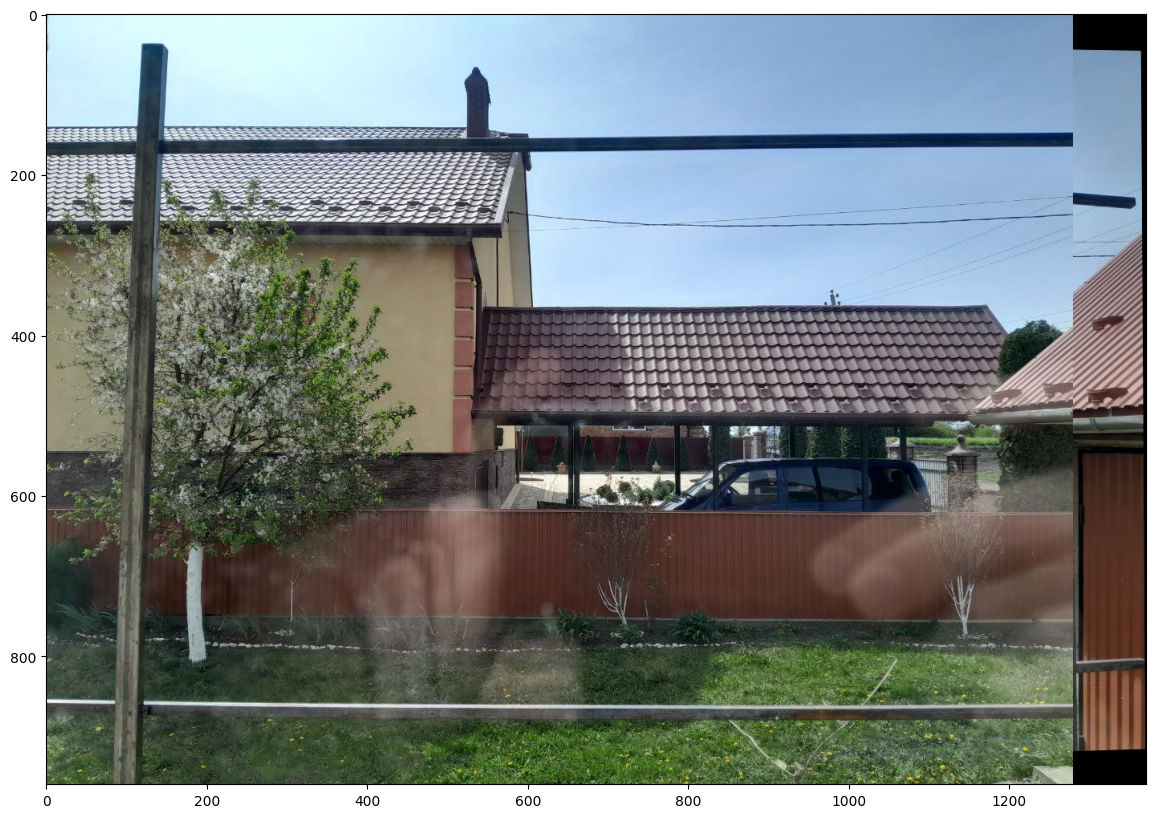

In [45]:
# Remove the unnecessary black filling
contour = np.sum(result, axis=-1)
bottom = np.max(np.argmin(contour, axis=0))
right = np.max(np.argmin(contour, axis=1))

# Final result
result = result[0:bottom, 0:right, :]
plt.imshow(result)

(<Axes: title={'center': 'Panorama'}>,
 Text(0.5, 1.0, 'Panorama'))

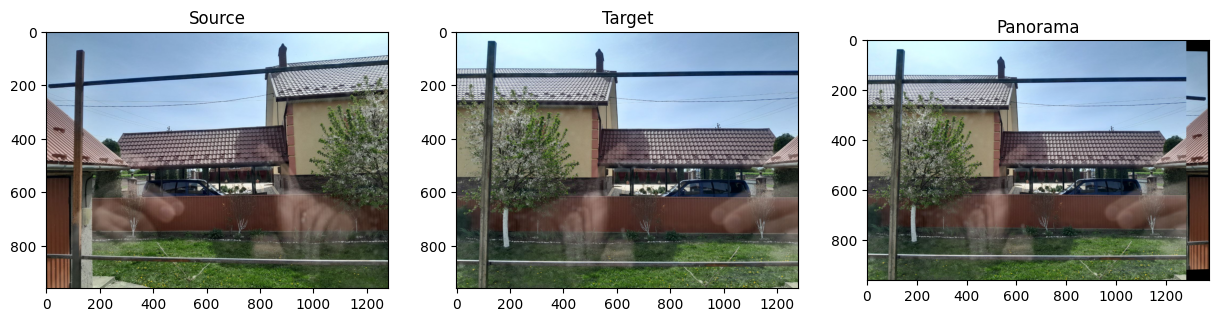

In [46]:
# Let's plot the three images together for better comparison
plt.subplot(131), plt.imshow(img_src), plt.title('Source')
plt.subplot(132), plt.imshow(img_dst), plt.title('Target')
plt.subplot(133), plt.imshow(result), plt.title('Panorama')

Додаткове завдання 2 (Дослідження зшивання зображень)

Додатково проведіть експерименти на базі ноутбуку Image Stitching та ваших зображень і дайте відповідь на запитання:
- Що буде, якщо один з рисунків перевернути догори ногами? На 90 градусів ? Чи буде наведений алгоритм зшивання зображень працювати ? Які будут кроки алгоритму для вирішення цієї проблеми? 
    - при повороті любого із зображень(на довільну кількість градусів) алгоритм буде коректно працювати. Тільки якщо повернутим буде зображення яке вище відображається як Target - то вихідне зображення також буде повернутим. Але в цілому - все працює правильно.
- Якщо візьмемо дзеркальне зображення сцени зі зміщенням? Чи правильно визначаться ключові точки, їх дескриптори та відбудеться зшивання зображень із застосуванням підходів із попереднього запитання? Чи можливо для вирішення цієї проблеми потрібні інша модель чи алгоритм?
    - А от з віддзеркаленим зображенням не все так чудово. Як мінімум вихідне зображення містить частину картинки яку потрібно було зшити, але не були збережені масштаби. На маю думку алгоритму помішали неправильно визначені лючові точки. Наприклад димар зєднувався з деревом. Ну і як вже знаю з ппереднього дослідження: поворот зображення не змінить нічого. А от чи треба іншої моделі або алгоритму - ну напевне да, бо результат не задовільний. :)
